# Top tagging model with ResNet-50 

This is a training script about using top tagging data to train a ResNet-50 Neuron Network. <br>
The training is base on Keras and using tensorflow backend to run.

## Import necessary package and do gpu test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

import h5py 
import os
from keras.utils import np_utils
import tensorflow as tf
from tqdm import tqdm


Using TensorFlow backend.


## Input data with H5py package
Input data size: 1 channel image with shape 224x224. <br>
Input label size: 1 or 0 with onehot encoding. <br>
\# of input data(train(with val), test): 30000,6000

In [2]:
f = h5py.File('data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z', 'r')
treeArray = f['t_allpar_new'][()]
features = ['j1_etarot', 'j1_phirot','j_index']
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']

In [3]:
features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

In [4]:
features_labels_df = features_labels_df.head(n = 750000)
features_df = features_labels_df[features].head(n = 750000)
labels_df = features_labels_df[labels].head(n = 750000)

In [5]:
MaxParticles = 30
BinsX = 224
MinX = -1.0
MaxX = 1.0
BinsY = 224
MinY = -1.0
MaxY = 1.0

# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

# get features
features_2dval = np.zeros((len(labels_df), BinsX, BinsY))
for i in tqdm(range(0, len(labels_df))):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    xbins = np.linspace(MinX, MaxX, BinsX + 1)
    ybins = np.linspace(MinY, MaxY, BinsY + 1)

    x = features_df_i[features[0]]
    y = features_df_i[features[1]]
    w = features_df_i[features[2]]

    hist, xedges, yedges = np.histogram2d(x, y, weights=w, bins=(xbins, ybins))

    for ix in range(0, BinsX):
        for iy in range(0, BinsY):
            features_2dval[i, ix, iy] = hist[ix, iy]
features_val = features_2dval

100%|████████████████████████████████████████████████████████████████████████████| 14428/14428 [03:54<00:00, 61.63it/s]


In [6]:
features_val.shape

(14428, 224, 224)

In [7]:
images = np.stack([features_val, features_val, features_val],axis= -1)
label = labels_val

In [8]:
images.shape

(14428, 224, 224, 3)

In [9]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(images, label, test_size=0.2, random_state=42)

In [10]:
X_train_val.shape

(11542, 224, 224, 3)

In [11]:
X_test.shape

(2886, 224, 224, 3)

## Construsting a sequential 
Construst a model with Keras pre-configured ResNet-50 and one Dense layer with Softmax activation function. <br>
Using Earlystopping and custom callback function to prevent training from overfitting and collect ROC/AUC data point. 

In [12]:
model = tf.keras.models.Sequential([
tf.keras.applications.ResNet50(weights=None, pooling='max',classes=2048),
tf.keras.layers.Dense(1024,activation='relu'),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(5, activation='softmax'),
])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              27784064  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 29,887,365
Trainable params: 29,834,245
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train_val, y_train_val, batch_size = 64, epochs = 50, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Train on 8656 samples, validate on 2886 samples
Epoch 1/50
8656/8656 [==============================] - 59s 7ms/sample - loss: 0.6537 - accuracy: 0.8198 - val_loss: 5.1116 - val_accuracy: 0.2020
Epoch 2/50
8656/8656 [==============================] - 38s 4ms/sample - loss: 0.2004 - accuracy: 0.9419 - val_loss: 3.4460 - val_accuracy: 0.4040
Epoch 3/50
8656/8656 [==============================] - 38s 4ms/sample - loss: 0.1809 - accuracy: 0.9478 - val_loss: 6.4323 - val_accuracy: 0.2020
Epoch 4/50
8656/8656 [==============================] - 39s 4ms/sample - loss: 0.1541 - accuracy: 0.9573 - val_loss: 2.3898 - val_accuracy: 0.5090
Epoch 5/50
8656/8656 [==============================] - 38s 4ms/sample - loss: 0.1512 - accuracy: 0.9599 - val_loss: 2.1589 - val_accuracy: 0.5270
Epoch 6/50
8656/8656 [==============================] - 38s 4ms/sample - loss: 0.0939 - accuracy: 0.9777 - val_loss: 1.6058 - val_accuracy: 0.6057
Epoch 7/50
8656/8656 [==============================] - 38s 4ms/sample

## Define function to visualize learning curve and prediction. <br><br>

In [17]:
import sys, os
sys.path.insert(0,'lib')
from evaluation import makeRoc, learningCurveLoss

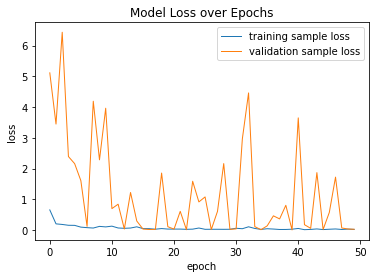

In [18]:
learningCurveLoss(history)

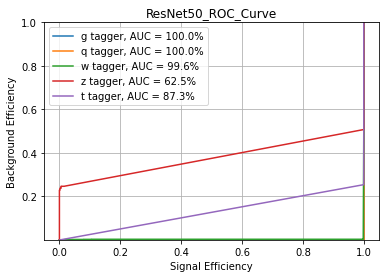

In [19]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='ResNet50')